# Student Performance Modeling

Approach:
1. Use train/test split data to try a number of different algorithms/techniques.
2. Choose the most promising algorithms and optimize hyperparameters.
3. Validate results using cross-validation on the entire dataset.

Algorithms to try:
- Linear regression
- K-Nearest Neighbors (KNN)
- Decision tree
- Support Vector Machine (SVM)
- Ensemble - RandomForest, XGBoost, stacking, etc
- Multi-layer perceptron (MLP)

Success criteria: 

Without knowledge of the first two term grades, the best model in the original paper had an root mean-squared error (RMSE) of 2.67 on the Portuguese dataset and 3.90 on the mathematics dataset. Since we are combining the two datasets, it may be difficult to compare our results with the results of the original paper. However, we are hoping to create a model that can produce results with a **RMSE of <2.75**. These results would demonstrate that the model has significant skill and is able to produce reasonably accurate predictions for a student's year-long grades. 

### Install and import libraries

In [1]:
!pip3 install --quiet mlflow

     |████████████████████████████████| 17.0 MB 142 kB/s 
     |████████████████████████████████| 181 kB 55.6 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 146 kB 65.6 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 58.1 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 


In [2]:
!pip3 install --quiet xgboost

In [3]:
!pip install --quiet tensorflow

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import pickle
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

### Creating directory for model artifacts

In [5]:
artifact_prefix = 'artifacts/'

In [6]:
!mkdir -p $artifact_prefix

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define contants

In [17]:
RAND_STATE = 12
TRAIN_FILE = '/content/drive/MyDrive/Colab Notebooks/Student-Performance-Prediction/data/processed/train.csv'
TEST_FILE = '/content/drive/MyDrive/Colab Notebooks/Student-Performance-Prediction/data/processed/test.csv'

### Load data into memory

In [18]:
train_df = pd.read_csv(TRAIN_FILE, header=0, index_col=0)
test_df = pd.read_csv(TEST_FILE, header=0, index_col=0)

Seperate attributes and target variable:

In [19]:
X_train = train_df.loc[:, train_df.columns != 'G3']
y_train = train_df['G3']
X_test = test_df.loc[:, test_df.columns != 'G3']
y_test = test_df['G3']

### Define model evaluation

In [20]:
# returns the root mean squared error (RMSE) and R-squared value given a set of predicted and actual values
def evaluate(actual, predictions):
    return mean_squared_error(y_true = actual, y_pred = predictions, squared = False), r2_score(actual, predictions)

### Create baseline naive model

We first want to create a baseline model to compare resuls as we test new algorithms. For our baseline regressor, we will be creating a naive model that always returns the average grade for students in the training set.

In [21]:
class NaiveRegressor(mlflow.pyfunc.PythonModel):
    def __init__(self):
        return
    def fit(self, X_train, y_train):
        # calculate average grade in training set
        self.value = np.average(y_train)
        return
    def predict(self, values):
        predictions = list()
        for row in np.array(values):
            predictions.append(self.value)
        return predictions

Now we want to evaluate our baseline model against the test dataset.

In [22]:
# create and train baseline model
baseline = NaiveRegressor()
baseline.fit(X_train, y_train)

In [24]:
# generate predictions
baseline_predictions = baseline.predict(X_test)

In [27]:
# evaluate predictions
baseline_score = evaluate(y_test, baseline_predictions)
print('Baseline RMSE: ', baseline_score[0])
print('Baseline R2:', baseline_score[1])

Baseline RMSE:  3.7025421957351212
Baseline R2: -0.01542370731080589


This baseline RMSE score is roughly consistent with the results found in the original paper. Although the original study separated math and Portuguese classes, the RMSE's of their Naive regression model were 4.59 and 3.23 respectively. We will log this model using MLFlow.

In [30]:
baseline_prefix = 'baseline/'
!mkdir -p {artifact_prefix + baseline_prefix}
baseline_model_path = artifact_prefix + baseline_prefix + 'model.pkl'
baseline_artifacts = {"baseline_model_path": baseline_model_path}
with open(baseline_model_path, 'wb') as f:
    pickle.dump(baseline, f)

In [31]:
with mlflow.start_run() as run:
    mlflow.log_metric("rmse", baseline_score[0])
    mlflow.log_metric("r2", baseline_score[1])
    
    mlflow.pyfunc.log_model(
        artifact_path='baseline',
        python_model=NaiveRegressor(),
        artifacts=baseline_artifacts,
    )

### Linear Regression

In [32]:
with mlflow.start_run():
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Evaluate Metrics
    predictions = lr.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)

    # Print out metrics
    print("Linear Regression model")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)

    # Log metrics and model to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(lr, "LinRegModel")

Linear Regression model
  RMSE: 3.3768350060298444
  R2: 0.15536913410091702


The scikit-learn Linear Regression model with default hyperparameters did improve over the baseline model. The RMSE improved to ~3.38 from 3.70 and the R-squared score improved from -0.02 to 0.15. Let's take a look at the coefficients assigned to each variable.

In [33]:
# create dictionary of col name, feature importance pairs
lr_coefficients = {}
for i in range(len(X_train.columns)):
    lr_coefficients[X_train.columns[i]] = lr.coef_[i]

lr_coefficients = dict(sorted(lr_coefficients.items(), key=lambda item: item[1], reverse=True))

print('Linear Regression Coefficients: ')
lr_coefficients

Linear Regression Coefficients: 


{'higher_yes': 1.3287625883988667,
 'Medu': 1.0313627454923857,
 'studytime': 1.012015095187876,
 'Fjob_teacher': 0.720778670879626,
 'internet_yes': 0.6385861598689289,
 'age': 0.45391953736215057,
 'address_U': 0.3621866504626178,
 'guardian_other': 0.18396566496064584,
 'Fjob_health': 0.028299359884970763,
 'guardian_father': -0.03985291591244975,
 'traveltime': -0.04827896039557578,
 'absences': -0.08082260402558895,
 'guardian_mother': -0.1441127490481975,
 'Fjob_other': -0.18797107447706116,
 'Fjob_at_home': -0.21062364781790222,
 'Fjob_services': -0.3504833084696297,
 'romantic_yes': -0.6491764311775738,
 'goout': -0.7111362481361766,
 'Dalc': -0.9419538957543623,
 'failures': -5.561951377793064}

The features that had the most positive effect on student's grades were the student wanting to pursue higher education, their mother's education level, and study time. The features that had the most negative effect on student's grades were past failed classes, weekday alcohol consumption, and how often they went out with their friends.

While the improvement in R-squared score is encouraging, there are few hyperparameters for linear regression and as a result, it is unlikely that we will be able to reach our success criteria with this algorithm. It's also possible that the relationship between the features and the target variable is not linear. We will explore some non-linear options next. 

### KNN

In [34]:
with mlflow.start_run():
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    # Evaluate Metrics
    predictions = knn.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)

    # Print out metrics
    print("KNN model")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)

    # Log metrics, and model to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(knn, "KNNModel")

KNN model
  RMSE: 3.6147844564602556
  R2: 0.03214103356534348


The motivation behind trying KNN was that we previously thought that students who were close together in the feature space would be similar in many ways, including school performance. However, KNN only slightly outperformed the naive baseline model (RMSE was 3.62 instead of 3.70, R2 was 0.03 instead of -0.02). It is possible to slightly improve these results with different values of K but other algorithm may prove to be more suited for this problem.

### Decision Tree

In [35]:
with mlflow.start_run():
    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)

    # Evaluate Metrics
    predictions = dt.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)

    # Print out metrics
    print("Decision Tree model")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)

    # Log metrics, and model to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(dt, "DecisionTreeModel")

Decision Tree model
  RMSE: 4.279519332154689
  R2: -0.3565545134503241


Annotation(0.57409, 0.979167, 'X[4] <= 0.167\nsquared_error = 15.06\nsamples = 939\nvalue = 11.296')
Annotation(0.57409, 0.979167, 'X[17] <= 0.5\nsquared_error = 11.838\nsamples = 770\nvalue = 12.034')
Annotation(0.254344, 0.9375, 'X[1] <= 0.875\nsquared_error = 8.037\nsamples = 38\nvalue = 9.447')
Annotation(0.0461056, 0.895833, 'X[5] <= 0.875\nsquared_error = 5.608\nsamples = 35\nvalue = 9.857')
Annotation(0.0370436, 0.854167, 'X[2] <= 0.5\nsquared_error = 3.04\nsamples = 25\nvalue = 10.4')
Annotation(0.0252851, 0.8125, 'X[19] <= 0.5\nsquared_error = 2.5\nsamples = 20\nvalue = 10.0')
Annotation(0.016621, 0.770833, 'X[5] <= 0.125\nsquared_error = 2.417\nsamples = 12\nvalue = 9.5')
Annotation(0.0106091, 0.729167, 'squared_error = 0.0\nsamples = 1\nvalue = 12.0')
Annotation(0.0106091, 0.729167, 'X[0] <= 0.5\nsquared_error = 2.017\nsamples = 11\nvalue = 9.273')
Annotation(0.0120237, 0.6875, 'X[7] <= 0.12\nsquared_error = 1.65\nsamples = 10\nvalue = 9.5')


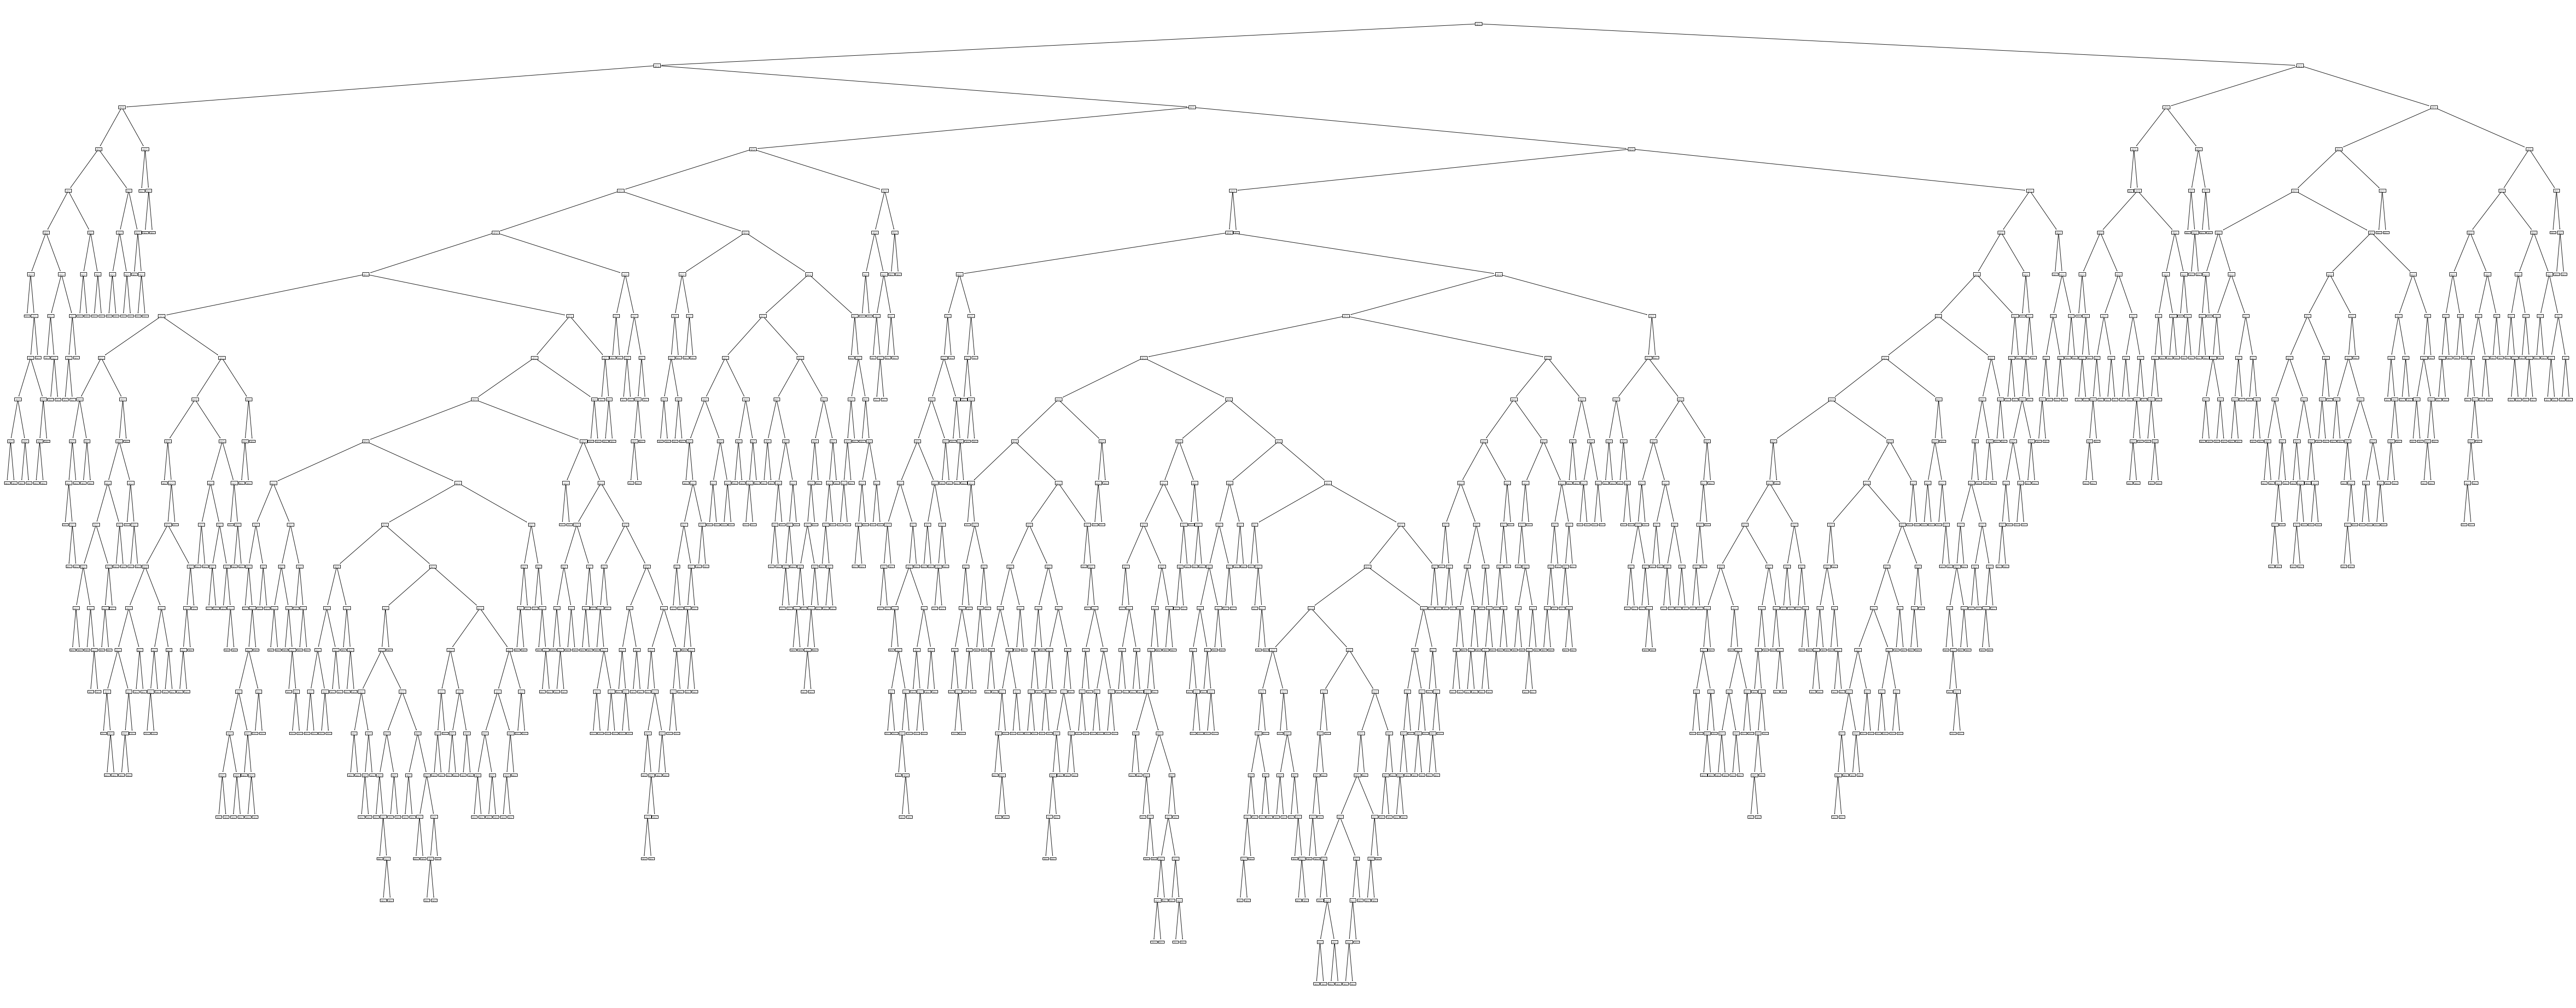

In [36]:
plt.rcParams['figure.figsize'] = [100, 40]
splits = tree.plot_tree(dt)
for i in range(10):
    print(splits[i])
# plt.show()

The scikit-learn Decision Tree regression algorithm with default hyperparameters is much worse than our baseline algorithm. We may try to tune some of the hyperparameters to see if it will do any better but for now, we will move on to other algorithm types.

### SVM

In [37]:
with mlflow.start_run():
    svm = SVR()
    svm.fit(X_train, y_train)

    # Evaluate Metrics
    predictions = svm.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)

    # Print out metrics
    print("SVM model")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)

    # Log metrics, and model to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(svm, "SVMModel")

SVM model
  RMSE: 3.254908124400312
  R2: 0.2152619080808369


The SVM algorithm from scikit-learn with default hyperparameters produced the best results so far. The model's RMSE on the test dataset was 0.12 lower than that of the linear regression model and its R2 score was 0.06 higher (both are better). 

### Random Forest

In [38]:
with mlflow.start_run():
    rf = RandomForestRegressor(random_state = RAND_STATE)
    rf.fit(X_train, y_train)
    
    # Evaluate metrics
    predictions = rf.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)
    
    # Print out metrics
    print("Random Forest Model")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)
    
    # Log metrics and model to MLFlow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    
    mlflow.sklearn.log_model(rf, "RFModel")

Random Forest Model
  RMSE: 3.150187508814912
  R2: 0.26494459446705376


In [39]:
# create dictionary of col name, feature importance pairs
rf_feat_importance = {}
for i in range(len(X_train.columns)):
    rf_feat_importance[X_train.columns[i]] = rf.feature_importances_[i]

rf_feat_importance = dict(sorted(rf_feat_importance.items(), key=lambda item: item[1], reverse=True))

print('Feature importances for Random Forest Regressor: ')
rf_feat_importance

Feature importances for Random Forest Regressor: 


{'absences': 0.19829099218846055,
 'failures': 0.17806188845882234,
 'age': 0.0892300090242936,
 'goout': 0.08220290093705118,
 'studytime': 0.07078737450175494,
 'Medu': 0.06251179659510459,
 'Dalc': 0.04648373994417617,
 'traveltime': 0.045733695446870275,
 'romantic_yes': 0.03261194740190056,
 'internet_yes': 0.027080768802731484,
 'address_U': 0.023326547843337948,
 'Fjob_services': 0.022603653364643525,
 'higher_yes': 0.02176807238361775,
 'Fjob_other': 0.0210077339862449,
 'Fjob_teacher': 0.018353891177157296,
 'guardian_father': 0.015908814784095542,
 'guardian_mother': 0.015561783439722867,
 'Fjob_at_home': 0.011657282002555136,
 'guardian_other': 0.010219246423643693,
 'Fjob_health': 0.006597861293815685}

The Random Forest algorithm from scikit-learn with default hyperparameters produced even better results than SVM, with a RMSE error of 3.15 (0.11 better than SVM) and an R2 of 0.27 (0.05 better than SVM). Random Forest is now our best performing algorithm without hyperparameter tuning.  

### XGBoost

For this algorithm, we will create a simple test harness that takes a dictionary of hyperparameters. The function will train an XGBoost model on the training data and print out the RMSE and R2 on the test data.

In [40]:
def xgboost_test_harness(params):
    with mlflow.start_run():
        dtrain = xgb.DMatrix(X_train, label=y_train)
        xgb_model = xgb.train(params, dtrain)
        
        dtest = xgb.DMatrix(X_test)
        predictions = xgb_model.predict(dtest)
        rmse, r2 = evaluate(y_test, predictions)

        # Print out metrics
        print("XGBoost Model")
        print("  RMSE: %s" % rmse)
        print("  R2: %s" % r2)
        
        # Log parameters, metrics, and model to MLFlow
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        mlflow.xgboost.log_model(xgb_model, "XGBModel")

In [41]:
params = {}
xgboost_test_harness(params)

XGBoost Model
  RMSE: 3.181878444061511
  R2: 0.25008086640082294


Despite the Decision Tree algorithm performing exceptionally poorly on this dataset, the XGBoost algorithm produced reasonably good results. XGBoost did not do as well as Random Forest but we may end up tuning both algorithms for a better comparison.

### Multi-Layer Perceptron

In [42]:
NUM_FEATURES = X_train.shape[1]
BATCH_SIZE = 32
EPOCHS = 15
VAL_SIZE = 0.3
LR = 0.05
MOMENTUM = 0.9

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=LR)

In [44]:
model = Sequential()
model.add(Dense(128, input_shape=(NUM_FEATURES,)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(optimizer=opt, loss='mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [46]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size = VAL_SIZE, random_state = RAND_STATE, shuffle=True)

In [47]:
with mlflow.start_run():
    history = model.fit(X_train_nn, y_train_nn, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val_nn, y_val_nn))
    
    # Evaluate model
    predictions = model.predict(X_test)
    rmse, r2 = evaluate(y_test, predictions)
    print("MLP")
    print("  RMSE: %s" % rmse)
    print("  R2: %s" % r2)
    
    # Log parameters, metrics, and model to MLFlow
    mlflow.log_param("learning_rate", LR)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("num_epochs", EPOCHS)
    mlflow.log_param("loss_function", 'mse')
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    
    mlflow.keras.log_model(model, "MLP_Model")

Epoch 1/15
21/21 [==============================] - 1s 13ms/step - loss: 59.1352 - root_mean_squared_error: 7.6899 - val_loss: 87.9817 - val_root_mean_squared_error: 9.3799
Epoch 2/15
21/21 [==============================] - 0s 3ms/step - loss: 37.1782 - root_mean_squared_error: 6.0974 - val_loss: 36.7272 - val_root_mean_squared_error: 6.0603
Epoch 3/15
21/21 [==============================] - 0s 4ms/step - loss: 29.8907 - root_mean_squared_error: 5.4672 - val_loss: 45.8922 - val_root_mean_squared_error: 6.7744
Epoch 4/15
21/21 [==============================] - 0s 4ms/step - loss: 24.8132 - root_mean_squared_error: 4.9813 - val_loss: 58.3958 - val_root_mean_squared_error: 7.6417
Epoch 5/15
21/21 [==============================] - 0s 4ms/step - loss: 26.2777 - root_mean_squared_error: 5.1262 - val_loss: 26.5823 - val_root_mean_squared_error: 5.1558
Epoch 6/15
21/21 [==============================] - 0s 4ms/step - loss: 22.5307 - root_mean_squared_error: 4.7467 - val_loss: 22.1608 - val

2022/08/26 19:25:00 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/26 19:25:06 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.14' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/26 19:25:06 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflo

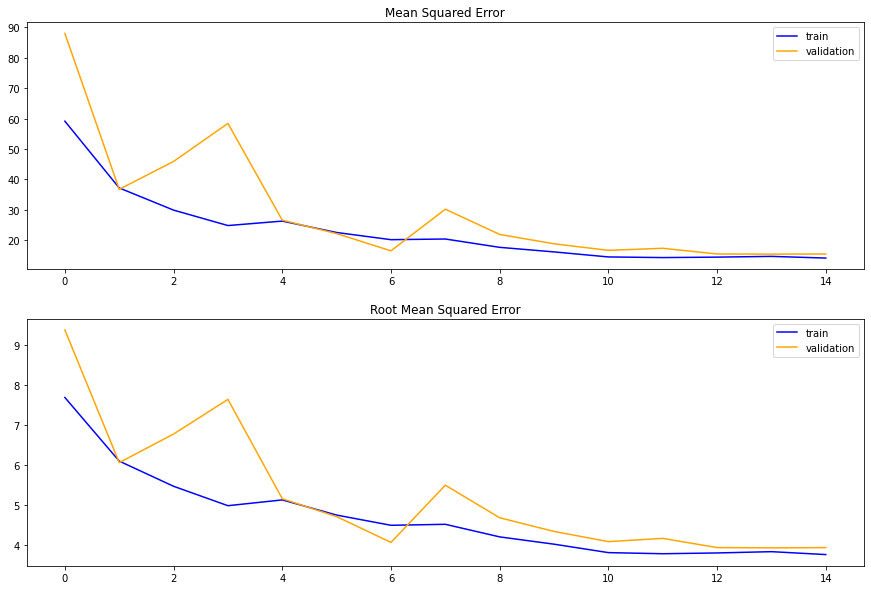

In [48]:
plt.rcParams['figure.figsize'] = [15, 10]

# plot loss
plt.subplot(211)
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend(loc='best')
# plot accuracy
plt.subplot(212)
plt.title('Root Mean Squared Error')
plt.plot(history.history['root_mean_squared_error'], color='blue', label='train')
plt.plot(history.history['val_root_mean_squared_error'], color='orange', label='validation')
plt.legend(loc='best')
plt.show()

After experimenting with various model architectures and hyperparameters, the best results we could obtain with an MLP were ~3.3 RMSE (due to the stochastic nature of the algorithm, results varied). This did not outperform the other algorithms and was much less consistent. 

### Hyperparameter tuning

In this section, we will be optimizing our top performing algorithms to see how much we can improve our results. Our current best models are:
1. Random Forest
2. XGBoost
3. SVM

We will use cross-validated grid search to optimize the hyperparameters for each algorithm. We will first need to read in the original dataset (before the split) and create a pipeline for the preprocessing and modeling. These preprocessing steps were developed in DataPreprocessing.ipynb and adapted for use on the entire dataset.

In [51]:
math_data = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/Colab Notebooks/Student-Performance-Prediction/data/student-mat.csv', sep=';', header=0)
port_data = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/Colab Notebooks/Student-Performance-Prediction/data/student-por.csv', sep=';', header=0)

df = pd.concat([math_data, port_data])

X = df.loc[:, df.columns != 'G3']
y = df['G3']

In [58]:
# define numerical attributes to keep
numeric_cols_to_keep = ['age', 'Medu', 'traveltime', 'studytime', 'failures', 'goout', 'Dalc', 'absences']
# define nominal attributes to keep
nominal_cols_to_keep = ['address', 'Fjob', 'guardian', 'higher', 'internet', 'romantic']

ct = ColumnTransformer(
         transformers = [("numeric", MinMaxScaler(), numeric_cols_to_keep),
                         ("nominal", OneHotEncoder(drop='if_binary', handle_unknown='error'), nominal_cols_to_keep)],
         remainder = 'drop',
         n_jobs = -1
)

We will start with **SVM**:

In [59]:
svm_params = {
    'svm__C': np.linspace(0.1, 3.0, num=5),
    'svm__epsilon': np.linspace(0.0, 1.0, num=5),
    'svm__kernel': ['poly', 'linear', 'rbf', 'sigmoid']
}

In [60]:
with mlflow.start_run():
    svm_pipeline = Pipeline(
        
        steps=[("preprocessor", ct), ("svm", SVR())]
    )
    svm_gs = GridSearchCV(
        estimator=svm_pipeline, 
        param_grid=svm_params, 
        scoring='neg_root_mean_squared_error',
        cv=5, 
        verbose=1
    )
    svm_gs.fit(X, y)
    
    rmse = svm_gs.best_score_ * -1 # sklearn uses a negative rmse so we invert it
    print("SVM model")
    print('  Best RMSE: ', rmse)

    # Log parameters, metrics, and model to MLflow
    print("Best hyperparameters: ", svm_gs.best_params_)
    for key, value in svm_gs.best_params_.items():
        if not type(value) == str: # MLFlow cannot log string parameters
            mlflow.log_param(key, value)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(svm_gs.best_estimator_, "Optimized_SVM_Model")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
SVM model
  Best RMSE:  3.445583961339967
Best hyperparameters:  {'svm__C': 3.0, 'svm__epsilon': 0.5, 'svm__kernel': 'rbf'}


We chose to optimize three hyperparameters for SVM: kernel, C, and epsilon. The RMSE we see here is slightly higher than the RMSE we saw for SVM on the split data. This difference is most likely attributable to the process of cross-validation, which provides a more realistic evaluation of the model's skill.  

We will now optimize our **XGBoost** algorithm:

In [61]:
xgb_params = {
    'xgb__max_depth': np.arange(2, 8, 2),
    'xgb__learning_rate': np.linspace(0.1, 0.5, 3),
    'xgb__n_estimators': np.arange(50, 250, 50),
    'xgb__reg_lambda': np.linspace(0, 1.0, 4) # L2 regularization
}

In [62]:
with mlflow.start_run():
    xgb_pipeline = Pipeline(
        steps=[("preprocessor", ct), ("xgb", xgb.XGBRegressor(seed = RAND_STATE))]
    )
    xgb_gs = GridSearchCV(
        estimator=xgb_pipeline,
        param_grid=xgb_params,
        scoring='neg_root_mean_squared_error',
        cv=5,
        verbose=1
    )
    xgb_gs.fit(X, y)
    
    rmse = xgb_gs.best_score_ * -1 # sklearn uses a negative rmse so we invert it
    print("XGBoost model")
    print('  Best RMSE: ', rmse)

    # Log parameters, metrics, and model to MLflow
    print("Best hyperparameters: ", xgb_gs.best_params_)
    for key, value in xgb_gs.best_params_.items():
        if not type(value) == str: # MLFlow cannot log string parameters
            mlflow.log_param(key, value)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(xgb_gs.best_estimator_, "Optimized_XGB_Model")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[19:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:54] WARNING: /workspace/src/objective/reg

Interestingly, we obtained slightly worse results after using grid search with XGBoost. This is most likely caused by the fact that GridSearchCV performs cross-validation, which trains the model on less data. These results indicate that we will not be able to drastically improve upon the results of the default XGBoost model with this dataset. 

We will now optimize our **random forest** algorithm.

In [64]:
rf_params = {
    'rf__max_depth': range(2, 20, 5), 
    'rf__n_estimators': range(50, 300, 50), 
    'rf__min_samples_leaf': range(1, 10, 3), 
    'rf__min_samples_split': range(2, 20, 5)
}

In [65]:
with mlflow.start_run():
    rf_pipeline = Pipeline(
        steps=[("preprocessor", ct), ("rf", RandomForestRegressor(random_state = RAND_STATE))]
    )
    rf_gs = GridSearchCV(
        estimator=rf_pipeline,
        param_grid=rf_params,
        scoring='neg_root_mean_squared_error',
        cv=5,
        verbose=1
    )
    rf_gs.fit(X, y)

    rmse = rf_gs.best_score_ * -1 # sklearn uses a negative rmse so we invert it
    print("XGBoost model")
    print('  Best RMSE: ', rmse)

    # Log parameters, metrics, and model to MLflow
    print("Best hyperparameters: ", rf_gs.best_params_)
    for key, value in rf_gs.best_params_.items():
        if not type(value) == str: # MLFlow cannot log string parameters
            mlflow.log_param(key, value)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(rf_gs.best_estimator_, "Optimized_RF_Model")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
XGBoost model
  Best RMSE:  3.392676692128402
Best hyperparameters:  {'rf__max_depth': 2, 'rf__min_samples_leaf': 7, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


Again, we obtained slightly worse results after optimization due to the decreased number of training samples used during cross-validation. These results indicate that we will not be able to drastically improve upon the results of the default RandomForest algorithm with this dataset.

### Summary

In this notebook, we tried several different algorithm including a naive baseline, KNN, decision tree, SVM, Random Forest, XGBoost, and multi-layer perceptron. The top performing algorithms on the hold-out set were Random Forest, XGBoost, and SVM. We then performed cross-validated grid search on each of the top performing algorithms to optimize the hyperparameters. We found the performance metrics to decline slightly during cross-validation compared to when we evaluated the models on the hold out dataset. However, the cross-validation score is a more realistic evaluation of the model's skill. Our best model was produced using the Random Forest algorithm, which produced an RMSE of ~3.39. While we did not meet our lofty goal of <2.75 RMSE, we roughly matched the results of the original paper (the original paper had an RMSE of 3.90 for the math class and 2.67 for the Portuguese class and we were close to the middle of that range with our combined dataset). We tried many different algorithms and were not able to decrease our error by any significant amount. Given this dataset, we believe there is a sizable irreducible error that cannot be prevented by any algorithm. One way that the results could be significantly improved would be to gather much more data. We believe that a lack of data is a contributing factor to the irreducible error present in this problem. 

This process was a great learning experience and provided the opportunity to learn MLFlow. We plan on taking our best algorithm and hyperparamters and demonstrating how to use Amazon Sagemaker to train and deploy a model with this dataset. See the aws folder for implementation details.